### HFM for Large N

The best way of solve this is avoiding the Z that grows as 2**n. To do this we need to rewrite our P(s) in terms of P(E) taking advantages of the hierarchical signatures of the model.

1) Proof distribution P(E)
2) Redo layers with P(E)
3) Create a phase space diagram of g vs eps vs Y
4) See the behavior on the derivatives of Y

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Distribución HFM --------------------------------------------------

def HFM_P_E(n, g):
    """
    Calcula la distribución P(E) para el modelo HFM.
    Returns:
    - E_vals: arreglo de valores posibles de E (0,1,...,n)
    - P_E: probabilidades P(E)
    """
    xi = 2 * np.exp(-g)
    # Partición Z
    if np.isclose(xi, 1.0):
        Z = 1 + n #Consistency with lim r->1
    else:
        Z = 1 + (xi**n - 1) / (xi - 1)

    E_vals = np.arange(n + 1)
    P_E = np.zeros(n + 1, dtype=float)
    P_E[0] = 1.0 / Z
    for E in range(1, n + 1):
        P_E[E] = (2**(E - 1)) * np.exp(-g * (E - 1)) / Z

    return E_vals, P_E

def sample_E(n, g):
    """
    Muestra un valor E ~ P(E).
    """
    E_vals, P_E = HFM_P_E(n, g)
    return np.random.choice(E_vals, p=P_E)

def sample_s(n, g):
    """
    A partir de un E muestreado, construye un vector s en {0,1}^n:
    - E = 0  -> s = [0,...,0]
    - E > 0  -> s[E-1] = 1, s[:E-1] ~ Bernoulli(0.5), resto 0
    Devuelve el vector s y el nivel E.
    """
    E = sample_E(n, g)
    s = np.zeros(n, dtype=int)
    if E > 0:
        s[E-1] = 1
        s[:E-1] = np.random.binomial(1, 0.5, size=E-1)
    return s, E

def sample_HFM(n, g, T):
    """
    Genera T muestras independientes de s ~ HFM, luego las mapea a {-1,+1}.
    Devuelve un array S de forma (T, n).
    """
    S = np.zeros((T, n), dtype=int)
    for t in range(T):
        s, _ = sample_s(n, g)
        S[t] = 2 * s - 1
    return S

# --- 2) Funciones de activación --------------------------------------------

def activation(z, func="sigmoid"):
    """
    Funciones de activación: step, sigmoid, tanh, relu.
    """
    if func == "step":
        return np.where(z >= 0, 1.0, -1.0)
    elif func == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif func == "tanh":
        return np.tanh(z)
    elif func == "relu":
        return np.maximum(0.0, z)
    else:
        raise ValueError(f"Función '{func}' no reconocida")

# --- 3) Simulación de capas (awareness) ------------------------------------

def simulate_layers(S, J=5, eps=0.1, func="sigmoid"):
    """
    Simula J capas de 'conciencia' a partir de la serie de estados S.
    - S: matriz de estados (T, n) en {-1,+1}
    - J: número de capas
    - eps: tasa de actualización (0<eps<=1)
    - func: función de activación
    Devuelve A de forma (T, J) con cada a_t^j.
    """
    T, n = S.shape
    A = np.zeros((T, J))
    W = np.random.normal(0, 1, size=(J, n))  # pesos aleatorios por capa
    a_vals = np.zeros(J)  # valores iniciales de cada capa

    for t in range(T):
        for j in range(J):
            z = W[j] @ S[t]
            out = activation(z, func=func)
            a_vals[j] = (1 - eps) * a_vals[j] + eps * out
            A[t, j] = a_vals[j]
    return A


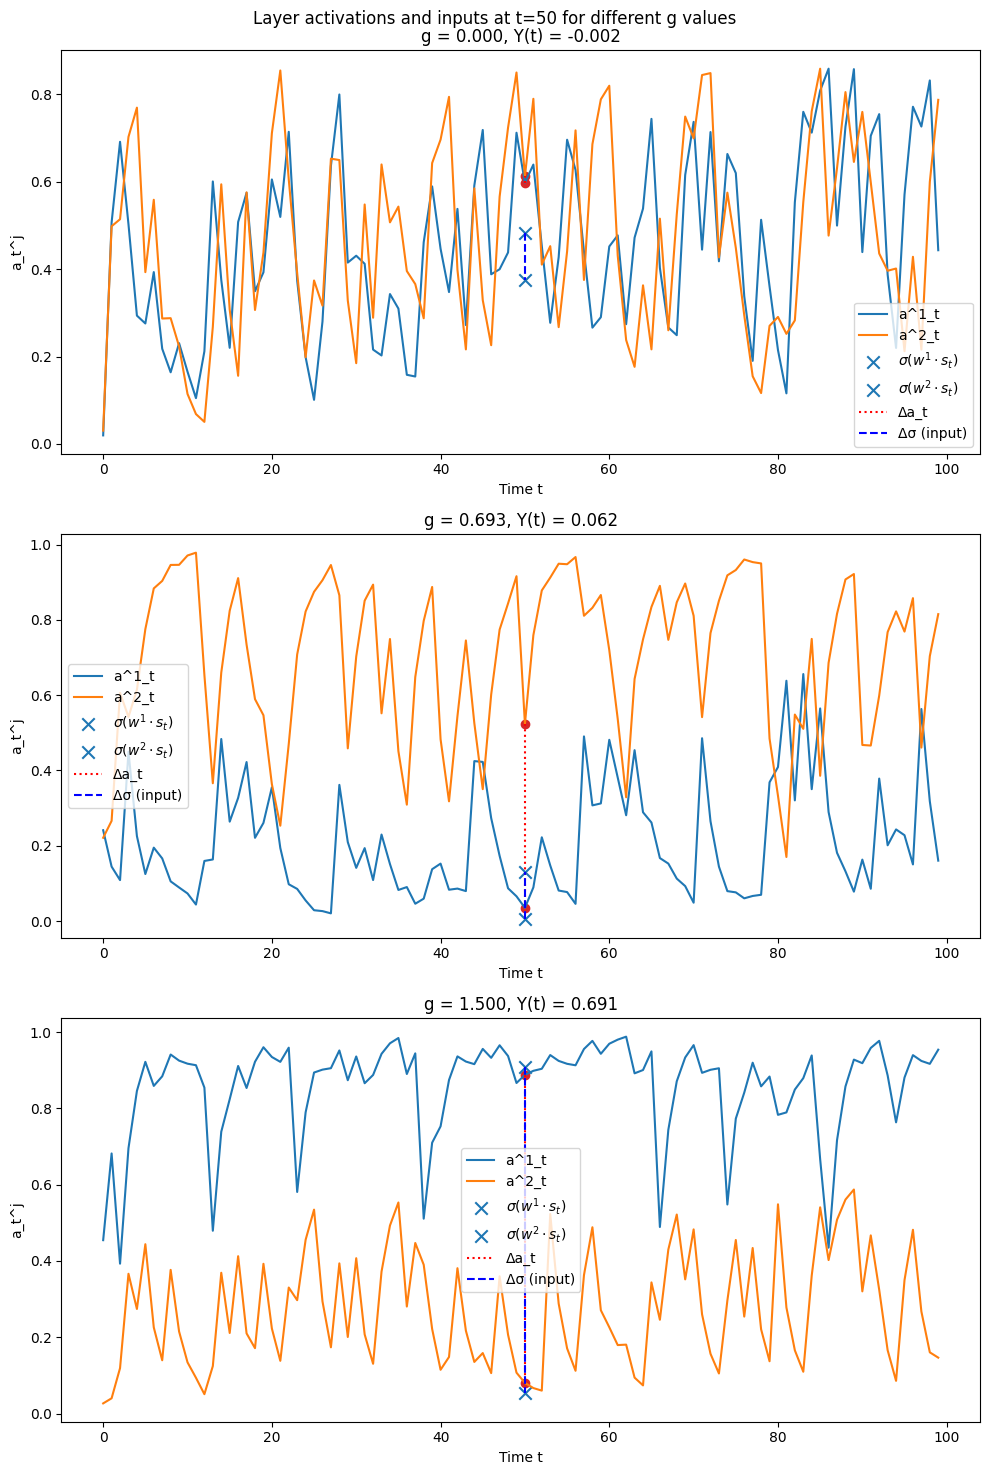

In [15]:

# Parameters
n = 10  # number of neuron
T = 100  # time steps 
J = 2  # number of layers
eps = 0.5  # memory parameter
g_values = [0, np.log(2), 1.5]  # different coupling strengths
t_star = 50  # fixed time to measure
func = "sigmoid"

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle(f"Layer activations and inputs at t={t_star} for different g values")

for idx, g in enumerate(g_values):
    # 1) Sample states from HFM
    S = sample_HFM(n=n, g=g, T=T)

    # 2) Fixed weights
    W = np.random.normal(0, 1, (J, n))

    # 3) Build activation matrix A
    A = np.zeros((T, J))
    a_vals = np.zeros(J)

    for t in range(T):
        for j in range(J):
            input_sum = np.dot(W[j], S[t])
            sigma_out = activation(input_sum, func=func)
            a_vals[j] = (1 - eps) * a_vals[j] + eps * sigma_out
            A[t, j] = a_vals[j]

    # 4) Calculate sigma inputs at t_star
    sigma_inputs = activation(W @ S[t_star], func=func)
    sig1, sig2 = sigma_inputs[0], sigma_inputs[1]

    # 5) Plot
    ax = axes[idx]
    ax.plot(A[:, 0], label='a^1_t', color='tab:blue')
    ax.plot(A[:, 1], label='a^2_t', color='tab:orange')

    # Mark points and differences
    ax.scatter([t_star], [A[t_star, 0]], color='tab:red')
    ax.scatter([t_star], [A[t_star, 1]], color='tab:red')
    ax.scatter([t_star], [sig1], color='tab:blue', marker='x', s=80, label=r'$\sigma(w^1 \cdot s_t)$')
    ax.scatter([t_star], [sig2], color='tab:blue', marker='x', s=80, label=r'$\sigma(w^2 \cdot s_t)$')
    ax.plot([t_star, t_star], [A[t_star, 0], A[t_star, 1]], color='red', linestyle=':', label='Δa_t')
    ax.plot([t_star, t_star], [sig1, sig2], color='blue', linestyle='--', label='Δσ (input)', linewidth=1.5)

    # Add SRA value
    delta_a = A[t_star, 0] - A[t_star, 1]
    delta_sigma = sig1 - sig2
    sra_value = delta_a * delta_sigma
    ax.set_title(f"g = {g:.3f}, Y(t) = {sra_value:.3f}")
    ax.set_xlabel('Time t')
    ax.set_ylabel('a_t^j')
    ax.legend()

plt.tight_layout()
plt.show()

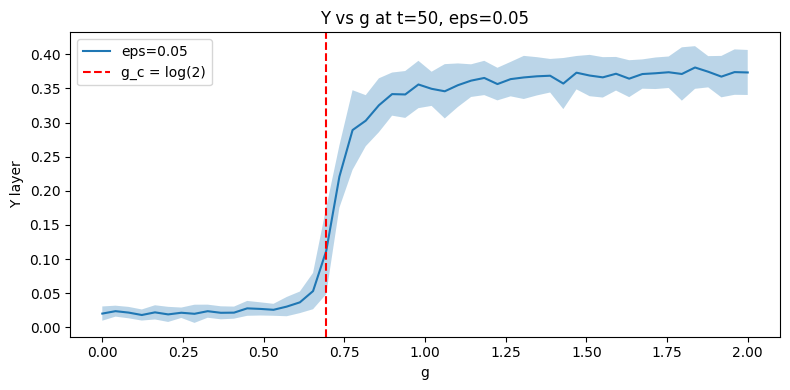

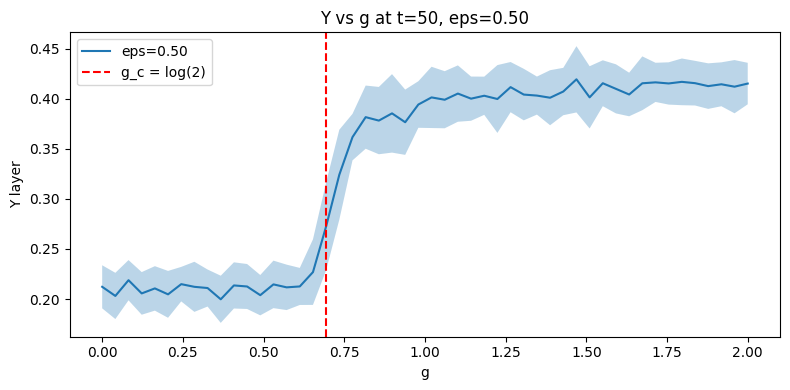

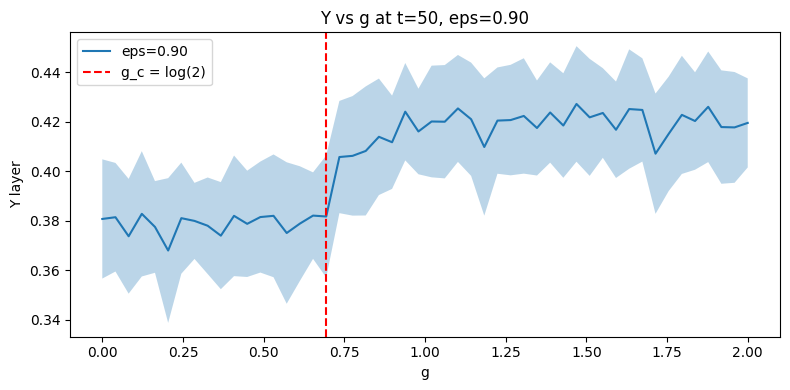

In [17]:
# --- 3) Cálculo de SRA score ---------------------------------------------

def Y_layer(A_t, sigma_inputs):
    J = len(A_t)
    score = 0.0
    num_pares = J * (J - 1) / 2
    for j in range(J):
        for j_prime in range(j + 1, J):
            delta_a = A_t[j] - A_t[j_prime]
            delta_sigma = sigma_inputs[j] - sigma_inputs[j_prime]
            score += delta_a * delta_sigma
    return score / num_pares

# Parámetros generales
n = 100              # longitud del vector s
T = 100             # pasos de tiempo
func = "sigmoid"    # función de activación
t_fixed = 50        # instante fijo para calcular SRA

J = 50                      # número de independent trials of a
n_samples = 30              # réplicas para promediar
g_values = np.linspace(0, 2, 50)
eps_values = [0.05, 0.5, 0.9]

# Bucle para cada eps
for eps in eps_values:
    mean_sra_scores = np.zeros(len(g_values))
    std_sra_scores = np.zeros(len(g_values))
    
    for i, g_val in enumerate(g_values):
        sra_scores = np.zeros(n_samples)
        
        for sample in range(n_samples):
            # 1) Generar estados y pesos
            S = sample_HFM(n, g_val, T)
            W = np.random.normal(0, 1, size=(J, n))
            
            # 2) Simular activaciones a_t^j
            A = np.zeros((T, J))
            a_vals = np.zeros(J)
            for t in range(T):
                for j in range(J):
                    out = activation(W[j] @ S[t], func=func)
                    a_vals[j] = (1 - eps) * a_vals[j] + eps * out
                    A[t, j] = a_vals[j]
            
            # 3) Entradas puras en t_fixed
            sigma_inputs = activation(W @ S[t_fixed], func=func)
            
            # 4) Calcular SRA score
            sra_scores[sample] = Y_layer(A[t_fixed], sigma_inputs)
        
        # Estadísticos
        mean_sra_scores[i] = sra_scores.mean()
        std_sra_scores[i] = sra_scores.std()
    
    # 5) Graficar curva de Y vs g con banda de desviación
    plt.figure(figsize=(8, 4))
    plt.plot(g_values, mean_sra_scores, label=f'eps={eps:.2f}')
    plt.fill_between(g_values, 
                     mean_sra_scores - std_sra_scores,
                     mean_sra_scores + std_sra_scores,
                     alpha=0.3)
    plt.axvline(x=np.log(2), color='r', linestyle='--', label='g_c = log(2)')
    plt.xlabel('g')
    plt.ylabel('Y layer')
    plt.title(f'Y vs g at t={t_fixed}, eps={eps:.2f}')
    plt.legend()
    plt.tight_layout()  
    plt.show()
# normalized over the J's (N* (N-1))/2

### Phase Space

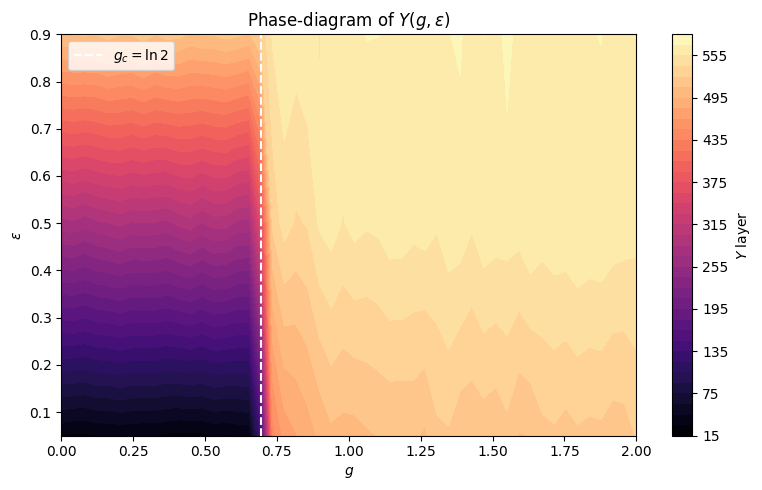

In [23]:
n = 500                   # longitud de s
T = 100                   # timesteps
t_fixed = 50              # instante de evaluación
func = "sigmoid"          # activación

J = 50                    # número de capas
n_samples = 30            # réplicas Monte Carlo

eps_values = [0.05, 0.5, 0.9]
g_values   = np.linspace(0, 2, 50)

Y_matrix = np.zeros((len(eps_values), len(g_values)))

for i_eps, eps in enumerate(eps_values):
    for i_g, g in enumerate(g_values):
        scores = np.zeros(n_samples)
        for sample in range(n_samples):
            S = sample_HFM(n, g, T)
            W = np.random.normal(0, 1, size=(J, n))
            # simular activaciones
            A = np.zeros((T, J))
            a_vals = np.zeros(J)
            for t in range(T):
                for j in range(J):
                    out = activation(W[j] @ S[t], func=func)
                    a_vals[j] = (1 - eps) * a_vals[j] + eps * out
                    A[t, j] = a_vals[j]
            # entradas crudas y SRA
            sigma_inputs = activation(W @ S[t_fixed], func=func)
            scores[sample] = Y_layer(A[t_fixed], sigma_inputs)
        Y_matrix[i_eps, i_g] = scores.mean()

# --- 5) Dibujar diagrama de fases -----------------------------------------

plt.figure(figsize=(8, 5))
plt.contourf(g_values, eps_values, Y_matrix, levels=40, cmap='magma')
plt.colorbar(label='$Y$ layer')
plt.axvline(np.log(2), color='w', linestyle='--', label='$g_c=\\ln2$')
plt.xlabel('$g$')
plt.ylabel('$\\varepsilon$')
plt.title('Phase‐diagram of $Y(g,\\varepsilon)$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Derivatives Y vs g

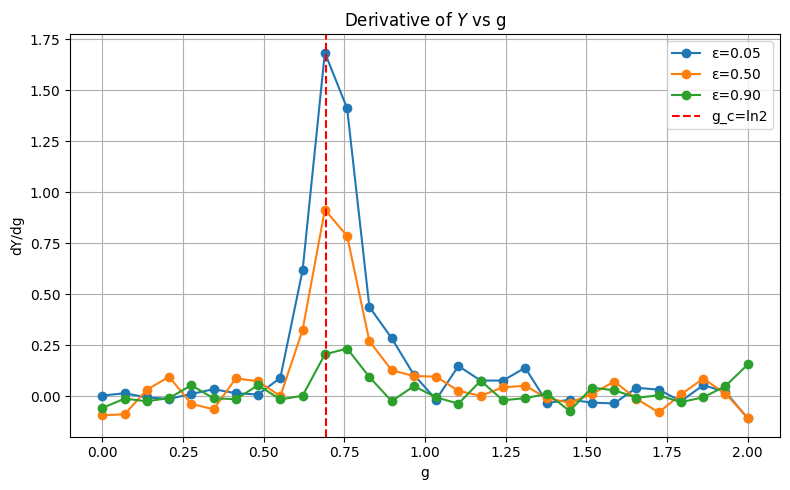

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# --- Funciones del modelo HFM y SRA ---------------------------------------

def HFM_P_E(n, g):
    xi = 2 * np.exp(-g)
    if np.isclose(xi, 1.0):
        Z = 1 + n
    else:
        Z = 1 + (xi**n - 1) / (xi - 1)
    E_vals = np.arange(n + 1)
    P_E = np.zeros(n + 1, dtype=float)
    P_E[0] = 1.0 / Z
    for E in range(1, n + 1):
        P_E[E] = (2**(E - 1)) * np.exp(-g * (E - 1)) / Z
    return E_vals, P_E

def sample_E(n, g):
    E_vals, P_E = HFM_P_E(n, g)
    return np.random.choice(E_vals, p=P_E)

def sample_s(n, g):
    E = sample_E(n, g)
    s = np.zeros(n, dtype=int)
    if E > 0:
        s[E-1] = 1
        s[:E-1] = np.random.binomial(1, 0.5, size=E-1)
    return s

def sample_HFM(n, g, T):
    S = np.zeros((T, n), dtype=int)
    for t in range(T):
        s = sample_s(n, g)
        S[t] = 2*s - 1
    return S

def activation(z, func="sigmoid"):
    if func == "sigmoid":
        return 1/(1+np.exp(-z))
    elif func == "tanh":
        return np.tanh(z)
    elif func == "relu":
        return np.maximum(0.0, z)
    elif func == "step":
        return np.where(z>=0, 1.0, -1.0)
    else:
        raise ValueError

def Y_layer(A_t, sigma_inputs):
    J = len(A_t)
    num_pares = J * (J - 1) / 2
    score = 0.0
    for j in range(J):
        for j_prime in range(j+1, J):
            score += (A_t[j]-A_t[j_prime])*(sigma_inputs[j]-sigma_inputs[j_prime])
    return score/num_pares

# --- Parámetros de demostración (reducidos para velocidad) -----------------

n = 100
T = 100
t_fixed = 50
func = "sigmoid"

eps_values = [0.05, 0.5, 0.9]
g_values   = np.linspace(0,2,30)

J = 50        
n_samples = 30   

# --- Cálculo de la matriz Y(g, eps) ---------------------------------------

Y_matrix = np.zeros((len(eps_values), len(g_values)))

for i_eps, eps in enumerate(eps_values):
    for i_g, g in enumerate(g_values):
        scores = np.zeros(n_samples)
        for sample in range(n_samples):
            S = sample_HFM(n, g, T)
            W = np.random.normal(0,1,(J,n))
            # Simulación de capas
            A = np.zeros((T, J)); a_vals = np.zeros(J)
            for t in range(T):
                for j in range(J):
                    out = activation(W[j]@S[t], func=func)
                    a_vals[j] = (1-eps)*a_vals[j] + eps*out
                    A[t,j] = a_vals[j]
            sigma_inputs = activation(W@S[t_fixed], func=func)
            scores[sample] = Y_layer(A[t_fixed], sigma_inputs)
        Y_matrix[i_eps, i_g] = scores.mean()

# --- Cálculo de derivada dY/dg ---------------------------------------------

dY_dg = np.gradient(Y_matrix, g_values, axis=1)

# --- Plot de las derivadas ------------------------------------------------

plt.figure(figsize=(8,5))
for i, eps in enumerate(eps_values):
    plt.plot(g_values, dY_dg[i], marker='o', label=f'ε={eps:.2f}')
plt.axvline(np.log(2), color='r', linestyle='--', label='g_c=ln2')
plt.xlabel('g')
plt.ylabel('dY/dg')
plt.title('Derivative of $Y$ vs g')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Do the derivative 
#Check on real data
#RBN and DBM
#Y captures the persistance on the relation between a and Y. 

